In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Required Imports
from keras.layers import Flatten, Dense
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import os

In [ ]:
noOfClasses = 6
class_names = ['CuttingCaterpillar', 'CuttingWeevil', 'DieBack','Healthy', 'WhiteFly', 'Yellow']
learning_rate = 0.0001

epochs = 80
batch_size = 128
image_size = (224,224)

In [ ]:
# Define your dataset directory and parameters
dataset_dir = "/content/drive/Shareddrives/Thesis_Preparation/AB/Soursop"

In [ ]:
# Load all file paths and labels
file_paths = []
labels = []

class_names = ['CuttingCaterpillar', 'CuttingWeevil', 'DieBack','Healthy', 'WhiteFly', 'Yellow']
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name)
    for img_path in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, img_path))
        labels.append(label)

file_paths = np.array(file_paths)
labels = np.array(labels)

In [ ]:
# Split the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.20, stratify=labels, random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.20, stratify=train_labels, random_state=42
)

print(f"Total images: {len(file_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Testing images: {len(test_paths)}")

Total images: 3838
Training images: 2456
Validation images: 614
Testing images: 768


In [ ]:
def path_to_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = img / 255.0  # Normalize to [0, 1]
    # One-hot encode the label
    label = tf.one_hot(label, noOfClasses)  # num_classes should be defined earlier
    return img, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(path_to_image).batch(batch_size).shuffle(buffer_size=1000)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(path_to_image).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(path_to_image).batch(batch_size)

print(f"Training dataset: {len(train_paths)} images")
print(f"Validation dataset: {len(val_paths)} images")
print(f"Testing dataset: {len(test_paths)} images")

Training dataset: 2456 images
Validation dataset: 614 images
Testing dataset: 768 images


In [ ]:
# Model Selector Function
def get_model(model_name, noOfClasses, layers_to_unfreeze=10):
    if model_name == "VGG19":
        base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    elif model_name == "ResNet101":
        base_model = tf.keras.applications.ResNet101(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    elif model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    elif model_name == "DenseNet201":
        base_model = tf.keras.applications.DenseNet201(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    # Freeze all layers except the top layers
    for layer in base_model.layers[:-layers_to_unfreeze]:
        layer.trainable = False

    x = Flatten()(base_model.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=prediction)
    return model

In [ ]:
def initiateParams(className, model, lr, model_name):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, verbose=1, min_lr=1e-5)

    # Use .keras extension
    checkpoint = ModelCheckpoint(
        filepath=os.path.join("/content/drive/Shareddrives/Thesis_Preparation/AB/Saved_Models",
                             f"{className}_{model_name}.keras"),
        save_best_only=True,
        monitor="val_accuracy"
    )

    early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
    return model, [annealer, checkpoint, early_stopping]

In [ ]:
# Training Function
def modelFit(model, callbacks, train_dataset, valid_dataset, epochs, batch_size):
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
    )
    return history

In [ ]:
# List of available models to choose from
model_names = ["VGG19", "ResNet101", "InceptionV3", "DenseNet201"]

model_name = "DenseNet201"


print(f"\nTraining {model_name}...")
model = get_model(model_name, noOfClasses, layers_to_unfreeze=10)
model, callbacks = initiateParams("Model_", model, learning_rate, model_name)
history = modelFit(model, callbacks, train_dataset, val_dataset, epochs, batch_size)
print(f"{model_name} training complete. Model saved as {model_name}.h5.")


Training DenseNet201...
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.5958 - loss: 1.2096 - val_accuracy: 0.9853 - val_loss: 0.0770 - learning_rate: 1.0000e-04
Epoch 2/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.9982 - loss: 0.0265 - val_accuracy: 0.9951 - val_loss: 0.0275 - learning_rate: 1.0000e-04
Epoch 3/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9951 - val_loss: 0.0197 - learning_rate: 1.0000e-04
Epoch 4/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9967 - val_loss: 0.0151 - learning_rate: 1.0000e-04
Epoch 5/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9967 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 6/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9967 - val_loss: 0.0118 - learning_rate: 

In [ ]:
# Plot Training and Validation Loss/Accuracy
def plotOutput(history, modelName, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the actual number of epochs the model was trained for
    num_epochs = len(acc)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    # Use num_epochs for x-axis data to match the length of y data
    plt.plot(range(num_epochs), acc, label='Training Accuracy')
    plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    # Use num_epochs for x-axis data to match the length of y data
    plt.plot(range(num_epochs), loss, label='Training Loss')
    plt.plot(range(num_epochs), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(modelName + '_graph.png')
    plt.show()

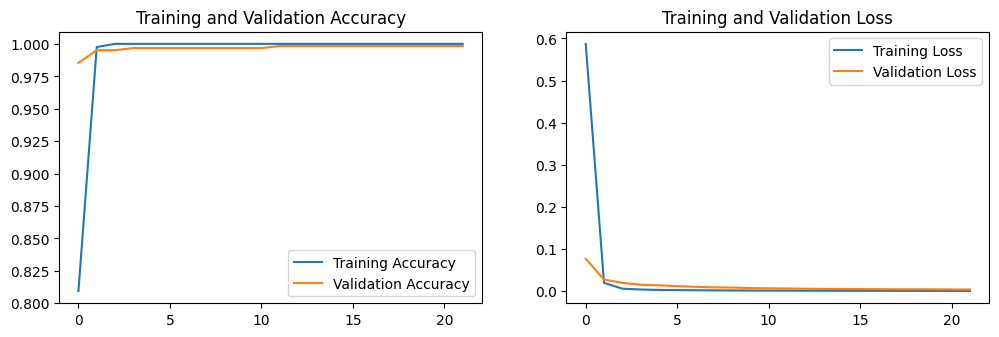

In [ ]:
plotOutput(history, model_name, 50)

Validation

In [ ]:
# Evaluation Function
def Validation(model, valid_dataset):
    evl = model.evaluate(valid_dataset)
    acc = evl[1] * 100
    msg = f'Accuracy on the Validation Set = {acc: .2f} %'
    print(msg)
    return acc

In [ ]:
accuracy = Validation(model, val_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9980 - loss: 0.0055
Accuracy on the Validation Set =  99.84 %


5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step 


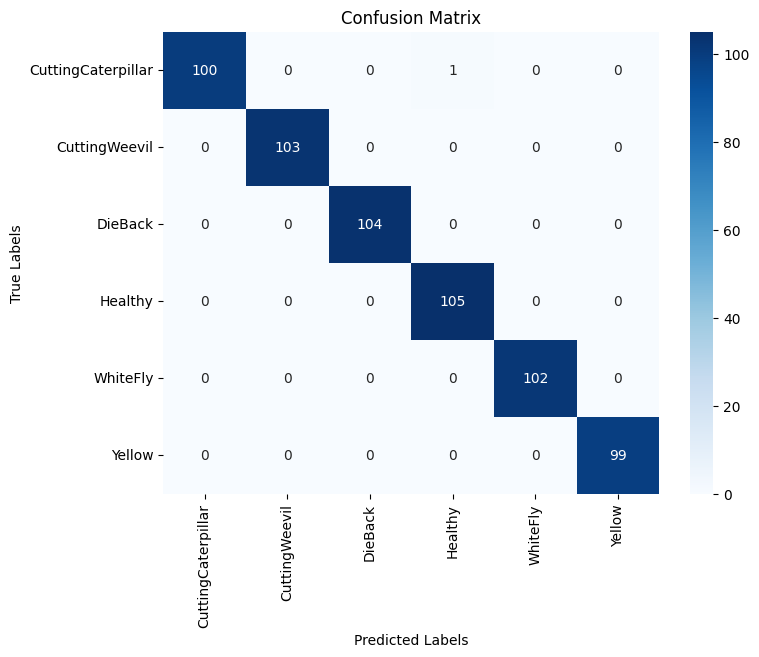

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred_prob = model.predict(val_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                    precision    recall  f1-score   support

CuttingCaterpillar       1.00      0.99      1.00       101
     CuttingWeevil       1.00      1.00      1.00       103
           DieBack       1.00      1.00      1.00       104
           Healthy       0.99      1.00      1.00       105
          WhiteFly       1.00      1.00      1.00       102
            Yellow       1.00      1.00      1.00        99

          accuracy                           1.00       614
         macro avg       1.00      1.00      1.00       614
      weighted avg       1.00      1.00      1.00       614



Testing

In [ ]:
# Evaluation Function
def evalModel(model, test_dataset):
    evl = model.evaluate(test_dataset)
    acc = evl[1] * 100
    msg = f'Accuracy on the Test Set = {acc: .2f} %'
    print(msg)
    return acc

In [ ]:
accuracy = evalModel(model, test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9942 - loss: 0.0164
Accuracy on the Test Set =  99.74 %


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


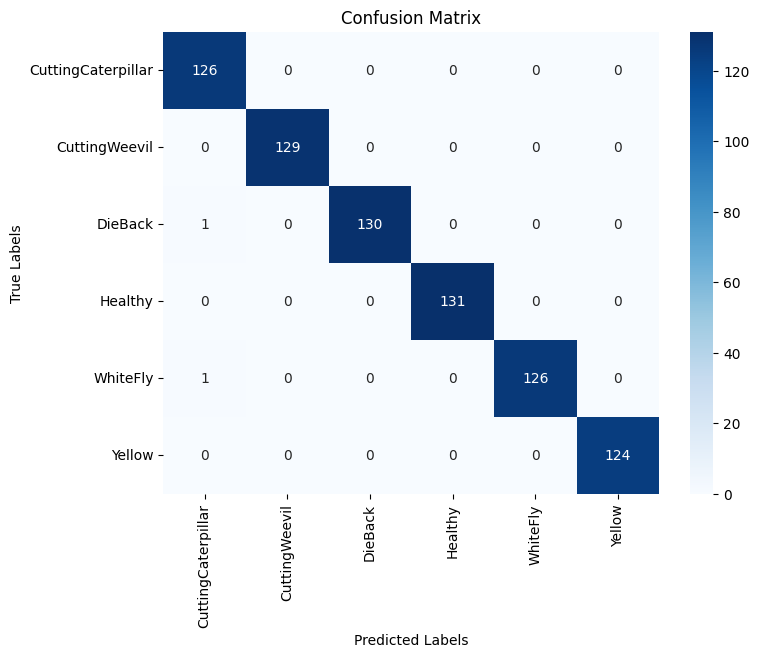

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                    precision    recall  f1-score   support

CuttingCaterpillar       0.98      1.00      0.99       126
     CuttingWeevil       1.00      1.00      1.00       129
           DieBack       1.00      0.99      1.00       131
           Healthy       1.00      1.00      1.00       131
          WhiteFly       1.00      0.99      1.00       127
            Yellow       1.00      1.00      1.00       124

          accuracy                           1.00       768
         macro avg       1.00      1.00      1.00       768
      weighted avg       1.00      1.00      1.00       768



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


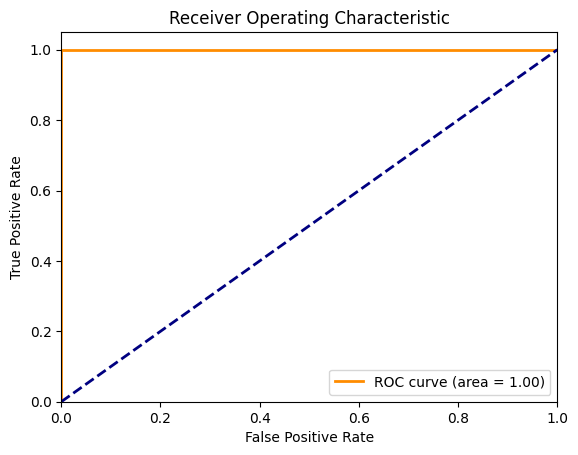

In [ ]:
# Predict probabilities for the test set
y_pred_prob = model.predict(test_dataset)

# Convert probabilities to binary predictions (e.g., for a binary classification problem)
# Assuming class 1 is the positive class
y_pred_binary = (y_pred_prob[:, 1] > 0.5).astype(int)

# Get the true labels for the positive class
y_true_binary = np.concatenate([y[:, 1] for x, y in test_dataset], axis=0)

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpcmsjb2ql'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140124970761872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961173008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961171472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961172624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961172240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961171856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961166864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961169552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961170320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140124961169744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012496117089